<img align="right" width="200" height="200" src="https://static.wikia.nocookie.net/lego/images/2/23/PPG_logo.png"> 

# <span style="color:#EF7C8E">Noon Perfume Model - Capstone Project - Building a content based filtering Model - Old data set  </span>
 


## <span style="color:#55BB99"> Group: Power Puff Girls</span>
### <span style="color:#726060"> Members: Wejdan Al-Ahmadi - Sara Aldubaie</span>
<hr style="border:2px solid gray"> </hr>

## * NOTE:* The models in this notebook were trained on the old dataset (1002 records)

In [1]:
#pip install fuzzywuzzy

In [2]:
#pip install python-Levenshtein

In [3]:
#!pip install recmetrics

In [4]:
#pip install funcsigs

In [5]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
from funcsigs import signature
import recmetrics

warnings.simplefilter(action='ignore', category=FutureWarning)

In [6]:
# data import
noon_clean = pd.read_csv('./data/noon_perfumes_dataset.csv')

In [7]:
noon_clean.head()

,Unnamed: 0,brand,name,old_price,new_price,ml,concentration,department,scents,base_note,middle_note,item_rating,seller,seller_rating,num_seller_ratings
0,0,PACO RABANNE,1 Million Lucky,395.0,244.55,100,EDT,Men,Woody,"Oakmoss, Patchouli and Vetiver","Hazelnut, Jasmine, Cashmir Wood, Cedar and Honey",5.0,noon,4.2,98.1K
1,1,Roberto Cavalli,Paradiso Assoluto,415.0,107.95,50,EDP,Women,Floral,"Vanilla, Sandalwood And Patchouli",Wild Jasmine and Red Lily,4.8,noon,4.2,98.1K
2,2,S.T.Dupont,Royal Amber,265.0,186.90,100,EDP,Unisex,Arabian,"Lemon, Mint and Wood Moss",Sandalwood and Cedar,5.0,noon,4.2,98.1K
3,3,GUESS,Seductive Blue,290.0,103.20,100,EDT,Men,Spicy,"Cashmere Wood, Moss And Rippled Sand Accord",Blue Coral Aquaspace Accord And Geranium,3.0,noon,4.2,98.1K
4,4,Roberto Cavalli,Uomo,260.0,94.95,50,EDP,Women,Arabian,"Vanille, Benzoin, Tonka Bean",African Orange Flower,4.8,noon,4.2,98.1K


In [8]:
noon_clean=noon_clean.drop(['Unnamed: 0'], axis=1)

In [9]:
# Data cleaning
brand_dict={'Dorall':'DORALL COLLECTION',
 'Al Rasasi':'Rasasi',
 'YVES':'Yves Saint Laurent',
 'YSL':'Yves Saint Laurent',
 'Benetton':'UNITED COLORS OF BENETTON',
 'LANVIN PARIS':'LANVIN',
 'Genie':'Genie Collection',
 'Justcavalli':'Roberto Cavalli',
 'Mont Blanc':'MONTBLANC',
 'Parfums Gres':'Gres',
 'EMPORIO ARMANI':'GIORGIO ARMANI' ,
 'ST Dupont':'S.T.Dupont' ,
 'Dupont':'S.T.Dupont',
 'Roberto':'Roberto Cavalli',
 'marbert man':'Marbert'}
noon_clean=noon_clean.replace({"brand": brand_dict})

noon_clean['middle_note'] = noon_clean['middle_note'].str.replace(' And',',')
noon_clean['middle_note'] = noon_clean['middle_note'].str.replace(' and',',')
noon_clean['base_note'] = noon_clean['base_note'].str.replace(' And',',')
noon_clean['base_note'] = noon_clean['base_note'].str.replace(' and',',')


In [10]:
noon_clean.columns = ['brand', 'name', 'old_price', 'price', 'Size', 'Concentration', 'Department', 
                     'scents' , 'Base Note' , 'Heart/Middle Note' , 'item_rating', 'seller', 'seller_rating', 
                      'num_seller_ratings']

In [11]:
noon_clean.isnull().sum()

brand                 0
name                  0
old_price             0
price                 0
Size                  0
Concentration         0
Department            0
scents                0
Base Note             0
Heart/Middle Note     0
item_rating           0
seller                0
seller_rating         0
num_seller_ratings    0
dtype: int64

In [12]:
noon_clean

,brand,name,old_price,price,Size,Concentration,Department,scents,Base Note,Heart/Middle Note,item_rating,seller,seller_rating,num_seller_ratings
0,PACO RABANNE,1 Million Lucky,395.0,244.55,100,EDT,Men,Woody,"Oakmoss, Patchouli, Vetiver","Hazelnut, Jasmine, Cashmir Wood, Cedar, Honey",5.0,noon,4.2,98.1K
1,Roberto Cavalli,Paradiso Assoluto,415.0,107.95,50,EDP,Women,Floral,"Vanilla, Sandalwood, Patchouli","Wild Jasmine, Red Lily",4.8,noon,4.2,98.1K
2,S.T.Dupont,Royal Amber,265.0,186.90,100,EDP,Unisex,Arabian,"Lemon, Mint, Wood Moss","Sandalwood, Cedar",5.0,noon,4.2,98.1K
3,GUESS,Seductive Blue,290.0,103.20,100,EDT,Men,Spicy,"Cashmere Wood, Moss, Rippled Sand Accord","Blue Coral Aquaspace Accord, Geranium",3.0,noon,4.2,98.1K
4,Roberto Cavalli,Uomo,260.0,94.95,50,EDP,Women,Arabian,"Vanille, Benzoin, Tonka Bean",African Orange Flower,4.8,noon,4.2,98.1K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998,GUESS,Dare,170.0,75.00,100,EDT,Women,Citrus,"Coconut Accords, Wood, Musk","Wild Rose, Elegant Jasmine",4.9,noon,4.2,98.1K
999,BURBERRY,For Women EDP Natural Sp,378.0,153.75,100,EDT,Women,Fruity,"Musk, Vanilla","Woody-Floral, Sandalwood, Cedar",4.8,noon,4.2,98.1K
1000,JOVAN,Musk Cologne Sp,55.0,19.00,59,EDT,Women,Woody,"Musk, Amber, Wood",Ylang-ylang,4.7,Cute,3.7,1.9K
1001,SWISS ARABIAN,Layali CPO At,126.0,77.00,15,EDT,Unisex,Arabian,"Agarwood, Amber","Ylang-Ylang, Rose, Jasmine",4.0,Swiss Arabian PerfumesPRICE UPDATE WITH 15% VA...,3.9,5


In [13]:
# get copy to work with cos sim and binary matrix 
noon_bin = noon_clean.copy()
# removing all white spaces to unify the notes
noon_bin['Heart/Middle Note'] = noon_bin['Heart/Middle Note'].str.replace(" ","")
noon_bin['Base Note'] = noon_bin['Base Note'].str.replace(" ","")

# applying the split by ',' to the base note column
noon_bin['Base Note']=noon_bin['Base Note'].apply(lambda x: x.split(","))
noon_bin['Heart/Middle Note']=noon_bin['Heart/Middle Note'].apply(lambda x: x.split(","))
#noon_bin['Top Note']=noon_bin['Top Note'].apply(lambda x: x.split(","))
#noon_bin.head()

In [14]:
from collections import Counter

# middle note freq counter
middle_note_counts = Counter(mn for middle_note in noon_bin['Heart/Middle Note'] for mn in middle_note)
print(f"There are {len(middle_note_counts)} Heart/Middle note labels.")


# base note freq counter
base_note_counts = Counter(bn for base_note in noon_bin['Base Note'] for bn in base_note)
print(f"There are {len(base_note_counts)} base note labels.")

print("Example of base notes counter:",base_note_counts.most_common(5))


There are 660 Heart/Middle note labels.
There are 446 base note labels.
Example of base notes counter: [('Musk', 351), ('Sandalwood', 297), ('Amber', 297), ('Vanilla', 250), ('Patchouli', 248)]


In [15]:
from itertools import dropwhile
# drop any note that has not been repeated at least once, because for our recommendation system to work we need at least 2
# frequencies of a note to make the recommendation



# middle notes
for key, count in dropwhile(lambda key_count: key_count[1] >= 2, middle_note_counts.most_common()):
    del middle_note_counts[key]
    
# base notes    
for key, count in dropwhile(lambda key_count: key_count[1] >= 2, base_note_counts.most_common()):
    del base_note_counts[key]
    
print(f"There are {len(middle_note_counts)} Heart/Middle note labels.")
print(f"There are {len(base_note_counts)} base note labels.")

There are 339 Heart/Middle note labels.
There are 230 base note labels.


In [16]:
# this is to handle the null values that were replaced by an empty string
del middle_note_counts['']
del base_note_counts['']

In [17]:

# Top 5 most common middle notes
print("The 5 most common middle notes: \n", middle_note_counts.most_common(5))
print('--'*50)
# Top 5 most common base notes
print("The 5 most common base notes: \n", base_note_counts.most_common(5))

The 5 most common middle notes: 
 [('Jasmine', 306), ('Rose', 183), ('Geranium', 97), ('Lavender', 65), ('Tuberose', 64)]
----------------------------------------------------------------------------------------------------
The 5 most common base notes: 
 [('Musk', 351), ('Sandalwood', 297), ('Amber', 297), ('Vanilla', 250), ('Patchouli', 248)]


In [18]:
# we need to create a binary matrix for the selected features, where the rows represent each perfume and the columns 
# represent the features, 1 means this perfume has this note and 0 means it does not

    
#-------------------------------------- MIDDLE NOTE-----------------------------------#

middle_notes = list(middle_note_counts.keys())

# create the binary matrix for middle notes
for mn in middle_notes:
    noon_bin[mn] = noon_bin['Heart/Middle Note'].transform(lambda x: int(mn in x))
#-------------------------------------- BASE NOTE-------------------------------------#

base_notes = list(base_note_counts.keys())

# create the binary matrix for base notes
for bn in base_notes:
    noon_bin[bn] = noon_bin['Base Note'].transform(lambda x: int(bn in x))
    

print('Middle notes Binary matrix \nrows: ', noon_bin[middle_notes].shape[0], '\ncolumns: ',noon_bin[middle_notes].shape[1])
print('--'*50)
print('Base notes Binary matrix \nrows: ', noon_bin[base_notes].shape[0], '\ncolumns: ',noon_bin[base_notes].shape[1])

Middle notes Binary matrix 
rows:  1003 
columns:  338
----------------------------------------------------------------------------------------------------
Base notes Binary matrix 
rows:  1003 
columns:  229


In [19]:
# save the binary matrix in a new variable

# middle note
perfume_features_MN = noon_bin[middle_notes]

# base note
perfume_features_BN = noon_bin[base_notes]

In [20]:
# concat all the notes to get all features
perfume_features = pd.concat([perfume_features_MN,perfume_features_BN], axis=1)
perfume_features.head()

,Hazelnut,Jasmine,Cedar,Honey,WildJasmine,RedLily,Sandalwood,Geranium,AfricanOrangeFlower,Lavender,...,oudh,drywoody-amber,SensualOrientalCharacter-GaiacWood,RangoonCreeper,Heliotropine,Patchoulie,Schijnhulst,CrystalMoss,WarmWoods,CoconutAccords
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
from sklearn.metrics.pairwise import cosine_similarity

# create a cosine similarity matrix using the binary matrix

# All note
cosine_sim_All = cosine_similarity(perfume_features, perfume_features)
print(f"Dimensions of our perfume features (All Notes) cosine similarity matrix: {cosine_sim_All.shape}")

# middle note
cosine_sim_MN = cosine_similarity(perfume_features_MN, perfume_features_MN)
print(f"Dimensions of our perfume features (Middle Notes) cosine similarity matrix: {cosine_sim_MN.shape}")

# base note
cosine_sim_BN = cosine_similarity(perfume_features_BN, perfume_features_BN)
print(f"Dimensions of our perfume features (Base Notes) cosine similarity matrix: {cosine_sim_BN.shape}")

Dimensions of our perfume features (All Notes) cosine similarity matrix: (1003, 1003)
Dimensions of our perfume features (Middle Notes) cosine similarity matrix: (1003, 1003)
Dimensions of our perfume features (Base Notes) cosine similarity matrix: (1003, 1003)


In [22]:
from fuzzywuzzy import process

# using the fuzzy wuzzy package, we can get the exact name of the perfume even if its misspelled 
def perfume_finder(name):
    all_names = noon_clean['name'].tolist()
    closest_match = process.extractOne(name,all_names)
    return closest_match[0]

In [23]:
# using 'Azurl' as an example I deliberatly spelt it wrong to demonstrate this
name = perfume_finder('Azurrll')
name

'Azure'

In [24]:
# we need to get the index of the 'Azurl' perfume in the cosine sim matrix to find recommendations for it

# this is a dictionary where the keys are perfume names and the values are perfume indices
perfume_idx = dict(zip(noon_bin['name'], list(noon_bin.index)))

# we get the index of the "Azurl" perfume using the name 
idx = perfume_idx[name]
idx

41

In [25]:
# get the top 10 similar perfumes to "Azurl"
n_recommendations=10
sim_scores = list(enumerate(cosine_sim_BN[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:(n_recommendations+1)]
similar_perfumes = [i[0] for i in sim_scores]

In [26]:
print(f"Because you liked {name}:")
noon_bin['name'].iloc[similar_perfumes]

Because you liked Azure:


192                  Gentlemen Only
606                       Emblem ED
644                  Cheap And Chic
85                        Good Girl
107                      Moon Light
803                       Good Girl
3                    Seductive Blue
44     La Nuit De L'Homme L'Intense
127                            Live
172                          Legend
Name: name, dtype: object

In [27]:
# this function takes the name of the perfume and how many recommendations and returns them both
def get_content_based_recommendations(name_string, note_type, rec_type='match',depart_filter='off' ):
    name = perfume_finder(name_string)
    idx = perfume_idx[name]
    rec_list=[]
    better_rec=[]  
    selected_depart=noon_clean[noon_clean['name']==name]['Department'].values[0]
    n_recommendations=30

    # for base note 
    if note_type == 'base':
        
        sim_scores = list(enumerate(cosine_sim_BN[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:(n_recommendations+1)]
        similar_perfumes = [i[0] for i in sim_scores]      
        list_names=list(noon_bin['name'].iloc[similar_perfumes])
        for i in list_names: 
            rec_depart=noon_clean[noon_clean['name']==i]['Department'].values[0]
            if(rec_depart==selected_depart):
                better_rec.append(i)
                
        rec_list=list(noon_bin['name'].iloc[similar_perfumes])

        
    # for middle note    
    elif note_type == 'middle': 
        
        sim_scores_m = list(enumerate(cosine_sim_MN[idx]))
        sim_scores_m = sorted(sim_scores_m, key=lambda x: x[1], reverse=True)
        sim_scores_m = sim_scores_m[1:(n_recommendations+1)]
        similar_perfumes_m = [i[0] for i in sim_scores_m]
        list_names=list(noon_bin['name'].iloc[similar_perfumes_m])
        for i in list_names: 
            rec_depart=noon_clean[noon_clean['name']==i]['Department'].values[0]
            if(rec_depart==selected_depart):
                better_rec.append(i)
        rec_list=list(noon_bin['name'].iloc[similar_perfumes_m])
        
    # for all note    
    elif note_type == 'all': 
        
        sim_scores_a2 = list(enumerate(cosine_sim_All[idx]))
        sim_scores_a2 = sorted(sim_scores_a2, key=lambda x: x[1], reverse=True)
        sim_scores_a2 = sim_scores_a2[1:(n_recommendations+1)]
        similar_perfumes_a2 = [i[0] for i in sim_scores_a2]
        list_names=list(noon_bin['name'].iloc[similar_perfumes_a2])
        for i in list_names: 
            rec_depart=noon_clean[noon_clean['name']==i]['Department'].values[0]
            if(rec_depart==selected_depart):
                better_rec.append(i)        
        rec_list=list(noon_bin['name'].iloc[similar_perfumes_a2])
        
    if(depart_filter=='on'):
        if(rec_type=='match'):
            better_rec=better_rec[0]
        elif(rec_type=='complement'):
            better_rec=better_rec[0:3]
    elif(depart_filter=='off'):
        if(rec_type=='match'):
            better_rec=rec_list[0]
        elif(rec_type=='complement'):
            better_rec=rec_list[0:3]
            
    return better_rec

In [28]:
perf_name='Azurl'

print(f"Base Note recommendations for {perf_name}:\n")
rec_list1 = get_content_based_recommendations(perf_name,'base','complement','on') 
print(rec_list1)

print(f"Base Note recommendations for {perf_name}:\n")
rec_list1 = get_content_based_recommendations(perf_name,'base','complement','off') 
print(rec_list1)



print(f"Middle Note recommendations for {perf_name}:\n")
rec_list3 = get_content_based_recommendations(perf_name,'middle','complement')
print(rec_list3)


print(f"All Note recommendations for {perf_name}:\n")
rec_list5 = get_content_based_recommendations(perf_name,'all','complement')
print(rec_list5)

Base Note recommendations for Azurl:

['Gentlemen Only', 'Emblem ED', 'Seductive Blue']
Base Note recommendations for Azurl:

['Gentlemen Only', 'Emblem ED', 'Cheap And Chic']
Middle Note recommendations for Azurl:

['In White', 'In White', 'The Scent']
All Note recommendations for Azurl:

['Gentlemen Only', 'Emblem ED', 'In White']


In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [30]:
# get copy to work with cos sim and TFIDF matrix
noon_tfidf=noon_clean.copy()

In [31]:
# get TF IDF of the base note column
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(noon_tfidf['Base Note'])

In [32]:
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)
#cosine_similarities

In [33]:
# this function takes the name of the perfume and how many recommendations and returns them both
def get_TFIDF_recommendations(name_string, n_recommendations=10):
    name = perfume_finder(name_string)
    idx = perfume_idx[name]
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(n_recommendations+1)]
    similar_perfumes = [i[0] for i in sim_scores]
    rec_list=list(noon_tfidf['name'].iloc[similar_perfumes])
    return rec_list

In [34]:
perf_name='Azurl'
print(f"Recommendations for {perf_name}:\n")
rec_list2 = get_TFIDF_recommendations(perf_name,5)
for i in rec_list2: 
    print(i)

Recommendations for Azurl:

Addict
Chloe
Encre Noire
Encre Noire
Encre Noire


In [35]:
test = noon_clean.copy()
test=test[['name','Department']]

In [36]:
#make recommendations for all perfumes in the test data

ran_recs = []
for name in test.name:
    random_predictions = noon_clean.name.sample(3).values.tolist()
    ran_recs.append(random_predictions)
        
test['random_predictions'] = ran_recs

In [37]:
#make recommendations for all perfumes in the test data

cos_ALL_recs = []
for name in test.name:
    cos_ALL_predictions = get_content_based_recommendations(name,'all','complement','off')
    cos_ALL_recs.append(cos_ALL_predictions)
        
test['cos_ALL_predictions'] = cos_ALL_recs

In [38]:
#make recommendations for all perfumes in the test data

cos_BN_recs = []
for name in test.name:
    cos_BN_predictions = get_content_based_recommendations(name,'base','complement','off')
    cos_BN_recs.append(cos_BN_predictions)
        
test['cos_BN_predictions'] = cos_BN_recs

In [39]:
#make recommendations for all perfumes in the test data

cos_MN_recs = []
for name in test.name:
    cos_MN_predictions = get_content_based_recommendations(name,'middle','complement','off')
    cos_MN_recs.append(cos_MN_predictions)
        
test['cos_MN_predictions'] = cos_MN_recs

In [40]:
#make recommendations for all perfumes in the test data

tfidf_recs = []
for name in test.name:
    tfidf_predictions = get_TFIDF_recommendations(name,3)
    tfidf_recs.append(tfidf_predictions)
        
test['tfidf_sim_predictions'] = tfidf_recs

In [41]:
# I divided by 3 because each rec system will give 3 recommendations per record
catalog = test.name.unique().tolist()
random_coverage = (recmetrics.coverage(ran_recs, catalog))/3
tfidf_coverage = (recmetrics.coverage(tfidf_recs, catalog))/3
cos_BN_coverage = (recmetrics.coverage(cos_BN_recs, catalog))/3
cos_ALL_coverage = (recmetrics.coverage(cos_ALL_recs, catalog))/3
cos_MN_coverage = (recmetrics.coverage(cos_MN_recs, catalog))/3

In [44]:
print(f"Coverage % of random reccomends for 5192 records: {round(random_coverage,2)}%\n")
print(f"Coverage % of cosine sim reccomends using TFIDF factorization and base notes for 1002 records: {round(tfidf_coverage,2)}%\n")
print(f"Coverage % of cosine sim reccomends using binary matrix and base notes for 1002 records: {round(cos_BN_coverage,2)}%\n")
print(f"Coverage % of cosine sim reccomends using binary matrix and all notes for 1002 records: {round(cos_ALL_coverage,2)}%\n")
print(f"Coverage % of cosine sim reccomends using binary matrix and middle notes for 1002 records: {round(cos_MN_coverage,2)}%\n")


Coverage % of random reccomends for 5192 records: 32.15%

Coverage % of cosine sim reccomends using TFIDF factorization and base notes for 1002 records: 26.49%

Coverage % of cosine sim reccomends using binary matrix and base notes for 1002 records: 25.65%

Coverage % of cosine sim reccomends using binary matrix and all notes for 1002 records: 26.94%

Coverage % of cosine sim reccomends using binary matrix and middle notes for 1002 records: 25.93%



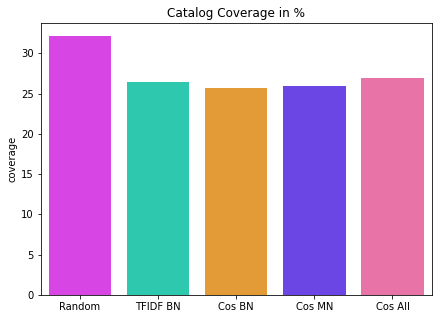

In [43]:
# plot of prediction coverage
coverage_scores = [random_coverage, tfidf_coverage,cos_BN_coverage,cos_MN_coverage,cos_ALL_coverage]
model_names = ['Random', 'TFIDF BN','Cos BN','Cos MN',"Cos All"]

fig = plt.figure(figsize=(7, 5))
recmetrics.coverage_plot(coverage_scores, model_names)